In [6]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import ndimage
from tqdm.notebook import tqdm

from fibrosisanalysis.parsers.image_loader import ImageLoader
from fibrosisanalysis.parsers.edge_loader import EdgeLoader
from fibrosisanalysis.parsers.stats_loader import StatsLoader
from fibrosisanalysis.slice.heart_slice import HeartSliceBuilder


cmap = colors.LinearSegmentedColormap.from_list(
            'fibrosis', [(0, 'white'),
                         (0.5, '#e2a858'),
                         (1, '#990102')])

path = Path('/Users/arstanbek/Hulk/Arstan/analysis/data')
path_stats = Path('/Users/arstanbek/Projects/fibrosis-workspace/fibrosisanalysis/examples/data')

heart = 'E11442_TTN'
n_angular = 36
n_radial = 3
node_step = 3

slice_names = Path(path_stats.joinpath(heart, 'Stats')).glob('*')
slice_names = [f.stem for f in slice_names if f.suffix == '.pkl']

density_map = {}

heart_slices = {}
for slice_name in tqdm(slice_names[:]):
    heart_slice_builder = HeartSliceBuilder()
    heart_slice = heart_slice_builder.build_from_file(path, heart, slice_name,
                                                      n_angular, n_radial,
                                                      node_step)
    heart_slices[slice_name] = heart_slice
    density_map[slice_name] = heart_slice.segment_density



  0%|          | 0/16 [00:00<?, ?it/s]

ValueError: Wrong number of labels 4 != 3

In [1]:
density_list = [d for k, d in density_map.items()]
density_list = np.array(density_list)


plt.figure()
plt.hist(density_list.ravel(), bins=100)
plt.show()

NameError: name 'density_map' is not defined

In [29]:
centroids = object_stats[['centroid-0', 'centroid-1']].to_numpy(dtype=int)
orientation = object_stats['orientation'].to_numpy(dtype=float)
segment_labels = heart_slice.total_segments[tuple(centroids.T)]

major_axis_length = object_stats['major_axis_length'].to_numpy(dtype=float)
minor_axis_length = object_stats['minor_axis_length'].to_numpy(dtype=float)
major_axis_length = np.where(major_axis_length >= 1, 0.5 * major_axis_length,
                             0.5)
minor_axis_length = np.where(minor_axis_length >= 1, 0.5 * minor_axis_length,
                             0.5)
axis_ratio = major_axis_length / minor_axis_length
orientation = object_stats['orientation'].to_numpy(dtype=float)
orientation = np.where(orientation < 0, orientation + np.pi, orientation)

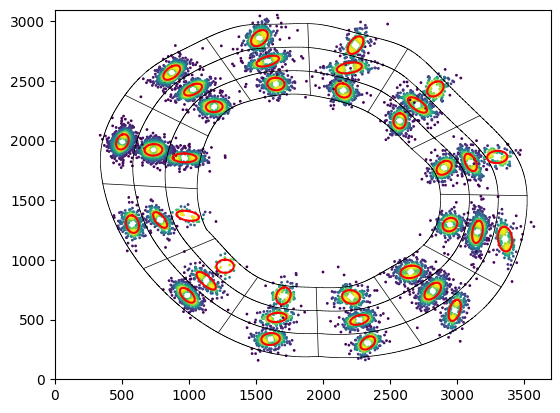

In [47]:
theta_range = np.linspace(0, 2 * np.pi, 100)
n_std = 1

plt.figure()

for spline_edge in heart_slice.spline_edges:
    plt.plot(spline_edge.full_nodes[:, 1], spline_edge.full_nodes[:, 0],
             'k', lw=0.5)
    
for i in range(len(heart_slice.spline_edges[0].ordered_nodes)):
    if i % 3 != 0:
        continue
    x = [heart_slice.spline_edges[0].ordered_nodes[i, 1],
         heart_slice.spline_edges[-1].ordered_nodes[i, 1]]
    y = [heart_slice.spline_edges[0].ordered_nodes[i, 0],
         heart_slice.spline_edges[-1].ordered_nodes[i, 0]]

    plt.plot(x, y, 'k', lw=0.5)

for segment_index in range(1, heart_slice.total_segments.max() + 1):
    r = np.concatenate((axis_ratio[segment_labels == segment_index],
                        axis_ratio[segment_labels == segment_index]))
    theta = np.concatenate((orientation[segment_labels == segment_index],
                            orientation[segment_labels == segment_index] + np.pi))

    r, theta, density = PointDensity.polar(r, theta)

    x, y = StruturalAnisotrophy.convert_to_cartesian(r, theta)

    dist_ellipses = DistributionEllipses('error')
    width, height, theta_ellipse = dist_ellipses.major_minor_axes(x, y, n_std)
    ellipse_radius = PointDensity.rotated_ellipse(0.5 * width, 0.5 * height, 
                                                  theta_range, theta_ellipse)
    
    rx, ry = np.argwhere(heart_slice.total_segments 
                         == segment_index).mean(axis=0)
    x = 30 * x + rx
    y = 30 * y + ry
    plt.scatter(y, x, c=density, s=1)
    plt.plot(ry + 30 * ellipse_radius * np.sin(theta_range),
             rx + 30 * ellipse_radius * np.cos(theta_range), color='red')
    
plt.xlim(0, heart_slice.image.shape[1])
plt.ylim(0, heart_slice.image.shape[0])
plt.show()


    # r_ellipse, theta_ellipse = StruturalAnisotrophy.anysotrophy(x, y)

    # fig, axs = plt.subplots(1, 1, subplot_kw=dict(projection="polar"))
    # axs.scatter(theta, r, c=density, s=1)

    # axs.plot(theta_range, ellipse_radius,
    #         label='{} (n_std={})'.format('error', n_std), color='red')
    # axs.set_rmax(10)
    # plt.show()

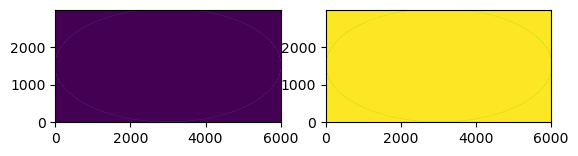

In [7]:
m0 = np.zeros_like(image, dtype=int)
m0[tuple(spline_edge.full_nodes.T)] = 1

m1 = (m0 == 0).astype(int)

fig, axs = plt.subplots(ncols=2)
axs[0].imshow(m0, origin='lower')
axs[1].imshow(m1, origin='lower')
plt.show()

In [8]:
from skimage import measure

%timeit measure.label(m0)

52.4 ms ± 998 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit measure.label(m1)

275 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
